# Import Libraries

In [63]:
# from gnews import GNews
from datetime import datetime, timedelta
import pandas as pd
# import os
# import re

import numpy as np
from sklearn import svm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
# from xgboost import XGBClassifier
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpstemmer import MPStemmer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import string
import pickle
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

# import tvDatafeed as tvd
# import json
# import talib
# from talib import abstract

# Global Variables

In [9]:
START_DATE = datetime.strptime('25-09-2018', "%d-%m-%Y")
END_DATE = datetime.strptime('25-09-2023', "%d-%m-%Y")
MAX_RES = 100
SITES_DICT = {
    'Bisnis.com': ('Bisnis', 'https://market.bisnis.com'),
    'CNBC Indonesia': ('CNBC', 'https://www.cnbcindonesia.com'),
    'Investor.ID': ('Investor', 'https://investor.id'),
    'Investasi Kontan' : ('Kontan', 'https://investasi.kontan.co.id')}
EMITEN = 'ADRO'
STOPWORDS_ID = StopWordRemoverFactory().create_stop_word_remover()

# Functions

## Data Collection Functions

### Function for News Extraction

In [3]:
def get_keywords_content_list(url):
    google_news = GNews(country="ID", language="id")
    article = google_news.get_full_article(url)
    article.nlp()
    keywords = article.keywords
    content = article.text
    return keywords, content

In [4]:
def gnews_getnews(start_date, end_date, max_res, site, emiten, country='ID', lang='id'):
    iteration = 1
    all_news = []
    temp_start = end_date - timedelta(days=max_res)
    while start_date < temp_start:
        
        print(f"Number of iteration = {iteration}")
        google_news = GNews(country=country, language=lang, start_date=temp_start, end_date=end_date, max_results=max_res)
        news = google_news.get_news(f"site:{site} {emiten}")
        for news_item in news:
            temp_date = re.search(r"\d{2}\s+\w{3}\s+\d{4}", news_item['published date'])[0]
            news_item['published date'] = datetime.strptime(temp_date, "%d %b %Y")
            if site != 'https://investor.id':
                news_item['keywords'], news_item['content'] = get_keywords_content_list(news_item['url'])
            else:
                news_item['keywords'], news_item['content'] = 'Missing', 'Missing'

        news = sorted(news, key=lambda x: x["published date"], reverse=True)
        all_news.extend(news)
        end_date = temp_start
        temp_start = temp_start - timedelta(days=max_res)
        iteration += 1
    print(f"Total data from {start_date} to {end_date} = {len(all_news)}")

    all_news = pd.DataFrame.from_dict(all_news)
    return all_news

## Data Preproces Functions

### Function for Text Preprocessing

In [4]:
def preprocess_title(row):
    sentence = row["title"]
    for publisher in SITES_DICT.keys():
        sentence = re.sub(publisher, " ", sentence)
    #remove numbers
    sentence = re.sub(r"\d+", "", sentence)
    #remove punctuation
    sentence = sentence.translate(str.maketrans("","",string.punctuation))
    #remove whitespace leading & trailing
    sentence = sentence.strip()
    #remove multiple whitespace into single whitespace
    sentence = re.sub('\s+',' ',sentence)
    #case folding
    sentence = sentence.lower()
    #tokenize
    #remove stopwords
    sentence = STOPWORDS_ID.remove(sentence)
    #stemming
    stemmer = MPStemmer()
    sentence = stemmer.stem_kalimat(sentence)

    return sentence

## Data Labelling Functions

### Function for Buy/Sell Labelling

In [6]:
def buysell_target(dataframe, days, price_col):
    # dataframe = dataframe.assign(target_days='None')
    target = 'None'
    for i in range(dataframe.shape[0] - days):
        if dataframe.loc[i + days, price_col] > dataframe.loc[i, price_col]:
            target = "buy"
        elif dataframe.loc[i + days, price_col] <= dataframe.loc[i, price_col]:
            target = "sell"
        dataframe.loc[i, f"target_{days}"] = target
    return dataframe

### Function for Pseudolabelling

In [78]:
def pseudolabelling(labelled_df, unlabelled_df, lower_threshold, psd_train_size, psd_test_size, psd_pipeline_model):

    # le = LabelEncoder()
    # le.fit(['negative', 'neutral', 'positive'])
    unlabelled_df.assign(sentiment= np.nan)
    psd_train_size = labelled_df.shape[0]
    psd_test_size = unlabelled_df.shape[0]

    temp_test_size = unlabelled_df.shape[0]
    threshold_acc_dict = {}
    threshold_iteration_dict = {}
    itera = 1
    proba_threshold = 0.95

    while(temp_test_size >= 1):
        proba_threshold = 0.95
        classifier = psd_pipeline_model

        y_proba = classifier.predict_proba(unlabelled_df['cleaned']) 
        index_label_proba = np.where(np.max(y_proba, axis=1) >= proba_threshold)[0]
        while(len(index_label_proba) < 1):
            proba_threshold = proba_threshold - 0.050
            index_label_proba = np.where(np.max(y_proba, axis=1) >= proba_threshold)[0]
            
        if proba_threshold < lower_threshold:
            return labelled_df, threshold_acc_dict, threshold_iteration_dict, classifier
                    
        index_label_proba_df = unlabelled_df.iloc[index_label_proba].index
        label_proba = np.argmax(y_proba[index_label_proba], axis=1)
        # label_proba = le.inverse_transform(label_proba)
        try:
            threshold_acc_dict[proba_threshold] += len(label_proba)
        except Exception:
            threshold_acc_dict[proba_threshold] = len(label_proba)

        for i in range(len(index_label_proba)):
            unlabelled_df.loc[index_label_proba_df[i], 'sentiment'] = label_proba[i]
        
        labelled_df = pd.concat([labelled_df, unlabelled_df.loc[index_label_proba_df]])
        unlabelled_df = unlabelled_df.drop(index_label_proba_df)
        temp_test_size = unlabelled_df.shape[0]
        threshold_iteration_dict[itera] = (proba_threshold, labelled_df.iloc[psd_train_size:].shape[0]/psd_test_size, labelled_df.iloc[psd_train_size:].shape[0])

        if itera % 5 == 0:
            print(itera, labelled_df.iloc[psd_train_size:].shape[0]/psd_test_size, labelled_df.iloc[psd_train_size:].shape[0])

        itera += 1

    return labelled_df, threshold_acc_dict, threshold_iteration_dict, classifier

## Data Fusion Functions

### Functions to Apply Final Sentiment

In [8]:
def apply_sentiment(row):
    sentiment = "no sentiment"

    if row["positive"] > row["negative"]:
        sentiment = "positive"
    elif row["negative"] > row["positive"]:
        sentiment = "negative"
    elif row["positive"] >= 1 and row["positive"] == row["negative"]:
        sentiment = "mixed"
    return sentiment

# Data Collection

## Historical Data Collection Process

In [8]:
# Import tradingview credentials
cred_path = 'credential.json'

with open(cred_path, 'r') as f:
    cred = json.load(f)

username = cred['username'][0]
password = cred['password'][0]

tv = tvd.TvDatafeed(username, password)

08/02/2024 09:56:33 AM - error while signin
08/02/2024 09:56:33 AM - you are using nologin method, data you access may be limited


In [13]:
# Count number of days
busday = np.busday_count((START_DATE - timedelta(days = 100)).strftime('%Y-%m-%d'), (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d'))
busday = int((abs(busday)//100 + 1) * 100)

# Collect Historical Data
stock_data = tv.get_hist(symbol=EMITEN.upper(), exchange='IDX', interval=tvd.Interval.in_daily, n_bars=busday)
stock_data.reset_index(inplace=True)
try:
    os.makedirs(f"Stock Data\{EMITEN}")
except Exception:
    pass
stock_data.to_csv(f"Stock Data\{EMITEN}\stock_{EMITEN.lower()}.csv", index=False)
stock_data

,datetime,symbol,open,high,low,close,volume
0,2017-12-20 09:00:00,IDX:BRPT,463.304516,463.304516,439.443340,445.408634,1.124012e+08
1,2017-12-21 09:00:00,IDX:BRPT,445.408634,459.327654,439.443340,453.362359,1.397634e+08
2,2017-12-22 09:00:00,IDX:BRPT,453.362359,457.339222,451.373928,451.373928,9.427833e+07
3,2017-12-27 09:00:00,IDX:BRPT,451.373928,463.304516,449.385497,459.327654,1.325507e+08
4,2017-12-28 09:00:00,IDX:BRPT,459.327654,463.304516,445.408634,449.385497,1.261467e+08
...,...,...,...,...,...,...,...
1595,2024-07-29 09:00:00,IDX:BRPT,1070.000000,1130.000000,1065.000000,1090.000000,2.795842e+08
1596,2024-07-30 09:00:00,IDX:BRPT,1095.000000,1110.000000,1070.000000,1075.000000,1.187908e+08
1597,2024-07-31 09:00:00,IDX:BRPT,1075.000000,1105.000000,1075.000000,1090.000000,1.202215e+08
1598,2024-08-01 09:00:00,IDX:BRPT,1105.000000,1125.000000,1095.000000,1120.000000,1.417771e+08


## News Data Collection Process

In [20]:
temp_dict = {}
temp_dict[EMITEN] = {}

## Data Collection
for site_name, site_tuple in SITES_DICT.items():
    site_shorten_name = site_tuple[0]
    site_link = site_tuple[1]
    print(f"{EMITEN} {site_name} {site_link}")
    temp_dict[EMITEN][site_shorten_name] = gnews_getnews(START_DATE, END_DATE, MAX_RES, site_link, EMITEN)

## Save data to files
for site, data in temp_dict[EMITEN].items():
    try:
        os.makedirs(f"News Data\{EMITEN}")
    except Exception:
        pass
    data.to_csv(f"News Data\{EMITEN}\\news_{site.lower()}_{EMITEN.lower()}.csv", index=False)

del temp_dict
print(f'CSVs for {EMITEN} created successfully')

In [49]:
# Merge news data
path = f"News Data/{EMITEN}/news_{SITES_DICT['Bisnis.com'][0].lower()}_{EMITEN.lower()}.csv"
news_data = pd.read_csv(path)
for news in SITES_DICT.keys():
    if news == 'Bisnis.com':
        continue
    else:
        temp_df = pd.read_csv(f"News Data/{EMITEN}/news_{SITES_DICT[news][0].lower()}_{EMITEN.lower()}.csv")
    news_data = pd.concat([news_data, temp_df], ignore_index=True)
    
del temp_df
news_data.drop_duplicates(inplace=True)
news_data

,title,description,published date,url,publisher,keywords,content
0,Alva Milik Indika Energy (INDY) Pertimbangkan ...,Alva Milik Indika Energy (INDY) Pertimbangkan ...,2023-09-20,https://news.google.com/rss/articles/CBMicmh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['ventures', 'energy', 'indika', 'group', 'bei...",Tidak menutup kemungkinan bagi IMG anak usaha ...
1,"Menaksir Cuan Saham BRPT, MEDC, INDY dan ADRO ...","Menaksir Cuan Saham BRPT, MEDC, INDY dan ADRO ...",2023-09-20,https://news.google.com/rss/articles/CBMieWh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['medc', 'dibentuk', 'uptrend', 'indy', 'menak...","Saham BRPT, MEDC, INDY dan ADRO sudah tersenga..."
2,Benarkah Saham ADRO dan INDY Bakal Diuntungkan...,Benarkah Saham ADRO dan INDY Bakal Diuntungkan...,2023-09-19,https://news.google.com/rss/articles/CBMicmh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['tbk', 'energy', 'diuntungkan', 'berpotensi',...",PT Adaro Energy Indonesia Tbk. (ADRO) dan PT I...
3,"Saham MEDC Paling Cuan di IDX Energy, Kalahkan...","Saham MEDC Paling Cuan di IDX Energy, Kalahkan...",2023-09-19,https://news.google.com/rss/articles/CBMibmh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['medc', 'penutupan', 'energy', 'tbk', 'semest...",Saham emiten minyak dengan kapitalisasi pasar ...
4,Beda Resep BlackRock & Vanguard di Saham Batu ...,Beda Resep BlackRock & Vanguard di Saham Batu ...,2023-09-18,https://news.google.com/rss/articles/CBMid2h0d...,"{'href': 'https://market.bisnis.com', 'title':...","['resep', 'menyajikan', 'peristiwa', 'situs', ...",Konten Premium adalah artikel yang menyajikan ...
...,...,...,...,...,...,...,...
3139,"Kuartal I 2019, sektor pertambangan masih suli...","Kuartal I 2019, sektor pertambangan masih suli...",2019-04-25,https://news.google.com/rss/articles/CBMiWWh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['tbk', 'sulit', 'pertambangan', 'us', 'tumbuh...",Reporter: Yoliawan H | Editor: Wahyu T.Rahmawa...
3140,Melihat potensi saham-saham LQ45 dengan rasio ...,Melihat potensi saham-saham LQ45 dengan rasio ...,2019-02-22,https://news.google.com/rss/articles/CBMiYmh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['rasio', 'fundamental', 'lq45', 'sahamsaham',...",Reporter: Yoliawan H | Editor: Herlina Kartika...
3141,"Empat saham naik-turun, ini 10 saham LQ45 deng...","Empat saham naik-turun, ini 10 saham LQ45 deng...",2019-01-25,https://news.google.com/rss/articles/CBMicGh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['24', 'terkecil', 'tbk', 'sril', 'lq45', 'ink...",Reporter: Hasbi Maulana | Editor: Hasbi Maulan...
3142,Adaro Energy (ADRO) memperbarui susunan direks...,Adaro Energy (ADRO) memperbarui susunan direks...,2018-12-14,https://news.google.com/rss/articles/CBMiUWh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['tbk', 'energy', 'rapat', 'adaro', 'david', '...",Reporter: Amalia Fitri | Editor: Sanny Cicilia...


# Data Preprocess

## Historical Data Preprocess

In [156]:
## Create technical indicators
days = [5, 10, 20, 50]
for day in days:
    stock_data[f'SMA_{day}'] = talib.abstract.SMA(stock_data, timeperiod = day)
    stock_data[f'EMA_{day}'] = talib.abstract.EMA(stock_data, timeperiod = day)
stock_data['RSI'] = talib.abstract.RSI(stock_data, timeperiod = 14)
macd = talib.abstract.MACD(stock_data, fastperiod = 12, slowperiod = 26, signalperiod = 9)
stock_data['MACD'], stock_data['MACD_SIGNAL'] = macd['macd'], macd['macdsignal']
bb = talib.abstract.BBANDS(stock_data, timeperiod = 20, nbdevup = 2.0, nbdevdn = 2.0, matype = 0)
stock_data['UPPERBAND'], stock_data['MIDDLEBAND'], stock_data['LOWERBAND'] = bb['upperband'], bb['middleband'], bb['lowerband']

del macd, bb

In [157]:
## Drop Data Before Start Date
temp_date = str(START_DATE) + ' 09:00:00'
temp_index = stock_data[stock_data['datetime'] == temp_date].index[0]
temp_index = temp_index - 50
temp_df = stock_data.iloc[temp_index:].reset_index(drop=True)

## Drop Data After End Date
temp_date = str(END_DATE) + ' 09:00:00'
temp_index = temp_df[temp_df['datetime'] == temp_date].index[0]
temp_index = temp_index + 50
temp_df = temp_df[:temp_index + 1]

stock_data = temp_df
del temp_df, temp_date, temp_index

stock_data["datetime"] = stock_data["datetime"].apply(lambda x: x.replace(hour=00, minute=00))
stock_data

,datetime,symbol,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,...,SMA_20,EMA_20,SMA_50,EMA_50,RSI,MACD,MACD_SIGNAL,UPPERBAND,MIDDLEBAND,LOWERBAND
0,2018-07-12,IDX:BRPT,347.975495,377.801966,347.975495,370.842456,1.424580e+08,355.133848,360.295916,364.181211,...,394.256236,387.193605,436.003353,421.003184,40.638118,-24.186028,-22.312679,462.164807,394.256236,326.347665
1,2018-07-13,IDX:BRPT,371.836672,385.755692,371.836672,375.813535,1.388753e+08,361.695672,365.468456,362.391623,...,391.273589,386.109789,433.179781,419.231040,42.614307,-22.112692,-22.272681,456.881204,391.273589,325.665974
2,2018-07-16,IDX:BRPT,376.807750,381.778829,354.935005,365.871378,1.073670e+08,362.689888,365.602763,359.607819,...,388.191520,384.182321,430.236902,417.138505,39.763180,-21.029393,-22.024024,452.478079,388.191520,323.904961
3,2018-07-17,IDX:BRPT,365.871378,365.871378,350.958142,360.900299,1.008820e+08,364.280633,364.035275,358.911868,...,384.463211,381.964986,427.194602,414.933085,38.380485,-20.337557,-21.686730,445.937908,384.463211,322.988514
4,2018-07-18,IDX:BRPT,361.894515,361.894515,353.940789,353.940789,6.741998e+07,365.473691,360.670447,358.613603,...,380.884035,379.296015,423.973343,412.541230,36.468536,-20.118927,-21.373170,440.692204,380.884035,321.075866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,2023-11-29,IDX:BRPT,1013.378030,1053.314110,1008.386020,1028.354060,1.725248e+08,991.413186,1009.946394,1043.829291,...,1065.544535,1054.928512,1147.563259,1083.007160,46.029466,-30.142470,-22.345243,1208.056584,1065.544535,923.032485
1315,2023-11-30,IDX:BRPT,1028.354060,1073.282150,1013.378030,1043.330090,3.848151e+08,1001.397206,1021.074293,1032.846869,...,1067.790939,1053.823900,1139.576043,1081.451197,47.610948,-27.323568,-23.340908,1207.385249,1067.790939,928.196629
1316,2023-12-01,IDX:BRPT,1048.322100,1053.314110,1013.378030,1013.378030,1.030839e+08,1007.387618,1018.508872,1017.870839,...,1066.542937,1049.971913,1130.290904,1078.781661,44.784445,-27.192986,-24.111324,1207.606752,1066.542937,925.479121
1317,2023-12-04,IDX:BRPT,1028.354060,1048.322100,1003.394010,1013.378030,1.186541e+08,1021.365246,1016.798591,1005.390814,...,1063.547731,1046.486781,1120.905925,1076.216813,44.784445,-26.780786,-24.645216,1206.443962,1063.547731,920.651499


## News Data Preprocess

In [144]:
## Open labelled data
path = 'Labelled News Data\Labelled_News_All.csv'
labelled_news_data = pd.read_csv(path)
labelled_news_data.drop(labelled_news_data.columns[0], axis=1, inplace=True)
labelled_news_data['cleaned'] = labelled_news_data.apply(lambda x: preprocess_title(x), axis=1)
labelled_news_data

,title,sentiment,kode_emiten,cleaned,description,published date,url,publisher,keywords,content,published_date,kode_emitten
0,Pundi-pundi Konglomerat di Lapak Bursa Karbon ...,0.0,ADRO,pundipundi konglomerat lapak bursa karbon indo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"IHSG Diprediksi Lanjut Menguat, Cek Saham AKRA...",1.0,ADRO,ihsg prediksi kuat cek saham akra mdka pgeo tlkm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Indeks Bisnis-27 Melemah Awal Pekan, Saham AMR...",1.0,ADRO,indeks bisnis lemah pekan saham amrt akra intp...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"IHSG Dibuka Menguat, Saham CUAN, ASII, hingga ...",1.0,ADRO,ihsg buka kuat saham cuan asii ammn melesat pagi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Profil Tambang MUTU yang Bikin CUAN Milik Praj...,0.0,ADRO,profil tambang mutu bikin cuan milik prajogo p...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2841,Electronic City (ECII) menyiapkan Rp 72 miliar...,2.0,NaN,electronic city ecii rp miliar buyback saham,Electronic City (ECII) menyiapkan Rp 72 miliar...,2020-05-22,https://news.google.com/rss/articles/CBMidmh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['graha', 'electronic', 'rp', 'toko', 'sandy',...",ILUSTRASI. Pembukaan Toko Ke-57 Electronic Cit...,NaN,NaN
2842,Saham Sky Energy (JSKY) direkomendasikan beli ...,1.0,NaN,saham sky energy jsky rekomendasi beli jelang ...,Saham Sky Energy (JSKY) direkomendasikan beli ...,2019-08-13,https://news.google.com/rss/articles/CBMiYmh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['sky', 'split', 'rp', 'menguat', 'william', '...",ILUSTRASI. Pabrik Modul Panel Surya PT Sky Ene...,NaN,NaN
2843,"Yuan China menguat pada level 7,0438, Kamis si...",2.0,NaN,yuan china kuat level kamis siang wib,"Yuan China menguat pada level 7,0438, Kamis si...",2019-08-08,https://news.google.com/rss/articles/CBMia2h0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['70438', 'winartokontancoid', 'level', 'yuan'...",Reporter: Yudho Winarto | Editor: Yudho Winart...,NaN,NaN
2844,"Meski Astra Infra dan Transindo cabut, pembang...",1.0,NaN,astra infra transindo cabut bangun tol serpong...,"Meski Astra Infra dan Transindo cabut, pembang...",2019-07-07,https://news.google.com/rss/articles/CBMidGh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['triliun', 'wika', 'rp', 'trans', 'astra', 'c...",Reporter: Aloysius Brama | Editor: Wahyu T.Rah...,NaN,NaN


In [145]:
# EMITEN = 'INCO'
# news_data = pd.read_csv(f'Raw News Data\{EMITEN}\All_{EMITEN}.csv')
# if news_data.columns[0] == 'Unnamed: 0':
#     news_data.drop(news_data.columns[0], axis=1, inplace=True)
# ## Preprocess text
# news_data['cleaned'] = news_data.apply(lambda x: preprocess_title(x), axis=1)
# news_data

,title,description,published date,url,publisher,keywords,content,cleaned
0,Grup ABMM Favorit Lo Kheng Hong Kepincut Nikel...,Grup ABMM Favorit Lo Kheng Hong Kepincut Nikel...,2023-09-24,https://news.google.com/rss/articles/CBMicmh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['mitra', 'logistics', 'ckb', 'tambang', 'peng...","Entitas PT ABM Investama Tbk (ABMM), PT Cipta ...",grup abmm favorit lo kheng hong kepincut nikel...
1,"Dukung Program Pemerintah, ACE untuk Indonesia...","Dukung Program Pemerintah, ACE untuk Indonesia...",2023-09-22,https://news.google.com/rss/articles/CBMieWh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['sampah', '60', 'elektronik', 'melaksanakan',...","Smallest Font Largest Font\r\n\r\nBisnis.com, ...",dukung program perin ace indonesia bersih hadi...
2,"Permintaan Batu Bara Membaik, Simak Rekomendas...","Permintaan Batu Bara Membaik, Simak Rekomendas...",2023-09-21,https://news.google.com/rss/articles/CBMiemh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['rekomendasi', 'simak', 'batu', 'ton', 'harum...",Analis menilai perbaikan permintaan komoditas ...,minta batu bara baik simak rekomendasi saham h...
3,"Prediksi IHSG Besok Jelang FOMC, Rekomendasi S...","Prediksi IHSG Besok Jelang FOMC, Rekomendasi S...",2023-09-18,https://news.google.com/rss/articles/CBMicWh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['prediksi', 'rekomendasi', 'fed', 'sekuritas'...",IHSG diprediksi bergerak di rentang 6.889-7.02...,prediksi ihsg besok jelang fomc rekomendasi sa...
4,"Indah Kiat (INKP) Tawarkan Obligasi Rp2,30 Tri...","Indah Kiat (INKP) Tawarkan Obligasi Rp2,30 Tri...",2023-09-18,https://news.google.com/rss/articles/CBMifGh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['pabrik', 'triliun', 'rp230', 'obligasi', 'se...",PT Indah Kiat Pulp & Paper Tbk. (INKP) akan me...,indah kiat inkp tawar obligasi rp triliun bang...
...,...,...,...,...,...,...,...,...
1516,"Vale Indonesia (INCO) rombak susunan pengurus,...","Vale Indonesia (INCO) rombak susunan pengurus,...",2019-04-02,https://news.google.com/rss/articles/CBMiYmh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['susunannya', 'rupst', 'menyetujui', 'komisar...",Reporter: Krisantus de Rosari Binsasi | Editor...,vale indonesia inco rombak susun urus susun ko...
1517,Harga minyak WTI terkoreksi dari level terting...,Harga minyak WTI terkoreksi dari level terting...,2019-03-15,https://news.google.com/rss/articles/CBMiWWh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['prediksi', '2019', 'tertinggi', 'level', 'pe...",Reporter: Wahyu Tri Rahmawati | Editor: Wahyu ...,harga minyak wti koreksi level tinggi kontan
1518,Kinerja PT Vale Indonesia Tbk (INCO) 2019 dipr...,Kinerja PT Vale Indonesia Tbk (INCO) 2019 dipr...,2019-02-14,https://news.google.com/rss/articles/CBMiYGh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['2019', 'laba', 'ton', 'yanuar', 'inco', 'nik...",Reporter: Amalia Fitri | Editor: Azis Husaini\...,kinerja pt vale indonesia tbk inco proyeksi ne...
1519,Simak enam saham pilihan Binaartha Sekuritas -...,Simak enam saham pilihan Binaartha Sekuritas ...,2018-12-14,https://news.google.com/rss/articles/CBMiUGh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['simak', 'sekuritas', 'level', 'potensi', 'rp...","ILUSTRASI. Analis Binaartha Parama Sekuritas, ...",simak enam saham pilih binaartha sekuritas


# Data Labelling

## Historical Data Labelling

In [158]:
# target = 10
stock_data = buysell_target(stock_data, 10, "close")
unsliced_stock_data = stock_data.copy()
stock_data = stock_data.iloc[:-50]
stock_data

,datetime,symbol,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,...,EMA_20,SMA_50,EMA_50,RSI,MACD,MACD_SIGNAL,UPPERBAND,MIDDLEBAND,LOWERBAND,target_10
0,2018-07-12,IDX:BRPT,347.975495,377.801966,347.975495,370.842456,1.424580e+08,355.133848,360.295916,364.181211,...,387.193605,436.003353,421.003184,40.638118,-24.186028,-22.312679,462.164807,394.256236,326.347665,sell
1,2018-07-13,IDX:BRPT,371.836672,385.755692,371.836672,375.813535,1.388753e+08,361.695672,365.468456,362.391623,...,386.109789,433.179781,419.231040,42.614307,-22.112692,-22.272681,456.881204,391.273589,325.665974,sell
2,2018-07-16,IDX:BRPT,376.807750,381.778829,354.935005,365.871378,1.073670e+08,362.689888,365.602763,359.607819,...,384.182321,430.236902,417.138505,39.763180,-21.029393,-22.024024,452.478079,388.191520,323.904961,sell
3,2018-07-17,IDX:BRPT,365.871378,365.871378,350.958142,360.900299,1.008820e+08,364.280633,364.035275,358.911868,...,381.964986,427.194602,414.933085,38.380485,-20.337557,-21.686730,445.937908,384.463211,322.988514,sell
4,2018-07-18,IDX:BRPT,361.894515,361.894515,353.940789,353.940789,6.741998e+07,365.473691,360.670447,358.613603,...,379.296015,423.973343,412.541230,36.468536,-20.118927,-21.373170,440.692204,380.884035,321.075866,buy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,2023-09-19,IDX:BRPT,1437.698880,1457.666920,1407.746820,1432.706870,9.852224e+07,1352.834710,1364.940445,1256.488917,...,1183.880665,948.581740,1019.954813,83.169442,126.057662,103.010197,1439.284719,1169.877544,900.470368,sell
1265,2023-09-20,IDX:BRPT,1432.706870,1477.634960,1417.730840,1442.690890,9.809105e+07,1400.758006,1390.857260,1284.444173,...,1208.529258,962.359688,1036.532699,83.530371,131.021181,108.612394,1460.356632,1197.333599,934.310565,sell
1266,2023-09-21,IDX:BRPT,1447.682900,1497.603000,1432.706870,1477.634960,1.427811e+08,1440.694086,1419.783160,1319.388243,...,1234.158372,976.636836,1053.830827,84.762063,136.204421,114.130799,1494.578045,1221.295247,948.012448,sell
1267,2023-09-22,IDX:BRPT,1467.650940,1512.579030,1447.682900,1482.626970,1.148547e+08,1453.673312,1440.731097,1353.833112,...,1257.822048,990.913985,1070.646362,84.935388,139.111400,119.126919,1524.781831,1244.008892,963.235953,sell


## News Data Labelling

In [146]:
## pseudolabelling
psd_train_size = labelled_news_data.shape[0]
psd_test_size = news_data.shape[0]
print(psd_train_size, psd_test_size)

psd_pipeline_model = pickle.load(open('pseudolabelling_pipeline_model_pkl', 'rb'))
pseudolabelled_news_all, threshold_acc_dict, threshold_iteration_dict, classifier = pseudolabelling(labelled_news_data, news_data, 0.68, psd_train_size, psd_test_size, psd_pipeline_model)

## save the new model
pickle.dump(classifier, open('new_pseudolabelling_pipeline_model_pkl', 'wb'))
pseudolabelled_news_all

2846 1521
5 0.14464168310322156 220


,title,sentiment,kode_emiten,cleaned,description,published date,url,publisher,keywords,content,published_date,kode_emitten
0,Pundi-pundi Konglomerat di Lapak Bursa Karbon ...,0.0,ADRO,pundipundi konglomerat lapak bursa karbon indo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"IHSG Diprediksi Lanjut Menguat, Cek Saham AKRA...",1.0,ADRO,ihsg prediksi kuat cek saham akra mdka pgeo tlkm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Indeks Bisnis-27 Melemah Awal Pekan, Saham AMR...",1.0,ADRO,indeks bisnis lemah pekan saham amrt akra intp...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"IHSG Dibuka Menguat, Saham CUAN, ASII, hingga ...",1.0,ADRO,ihsg buka kuat saham cuan asii ammn melesat pagi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Profil Tambang MUTU yang Bikin CUAN Milik Praj...,0.0,ADRO,profil tambang mutu bikin cuan milik prajogo p...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1483,Selamat! MIND ID dapat harga murah Rp 2.780 pe...,2.0,NaN,selamat mind id harga murah rp saham saham inco,Selamat! MIND ID dapat harga murah Rp 2.780 pe...,2020-06-20,https://news.google.com/rss/articles/CBMia2h0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['penutupan', '20', 'vcl', 'murah', 'rp', 'sel...",Reporter: Azis Husaini | Editor: Azis Husaini\...,NaN,NaN
1485,Ini dampak pembatasan sosial yang dialami Agun...,2.0,NaN,dampak batas sosial alami agung podomoro land ...,Ini dampak pembatasan sosial yang dialami Agun...,2020-05-29,https://news.google.com/rss/articles/CBMiZmh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['laba', 'proyek', 'kuartal', 'pembatasan', 'l...",ILUSTRASI. Agung Podomoro Land (APLN) menyebut...,NaN,NaN
1491,Simak jadwal stock split Fast Food Indonesia (...,1.0,NaN,simak jadwal stock split fast food indonesia fast,Simak jadwal stock split Fast Food Indonesia (...,2020-02-06,https://news.google.com/rss/articles/CBMiVWh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['simak', '13', 'split', 'negosiasi', 'februar...","ILUSTRASI. Gerai KFC di SPBU Pertamina, Ciputa...",NaN,NaN
1499,Simak rekomendasi saham Profindo Sekuritas unt...,1.0,NaN,simak rekomendasi saham profindo sekuritas dag...,Simak rekomendasi saham Profindo Sekuritas unt...,2019-11-22,https://news.google.com/rss/articles/CBMia2h0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['rekomendasi', 'simak', 'sekuritas', 'terbent...",ILUSTRASI. Layar pergerakan saham di gedung Bu...,NaN,NaN


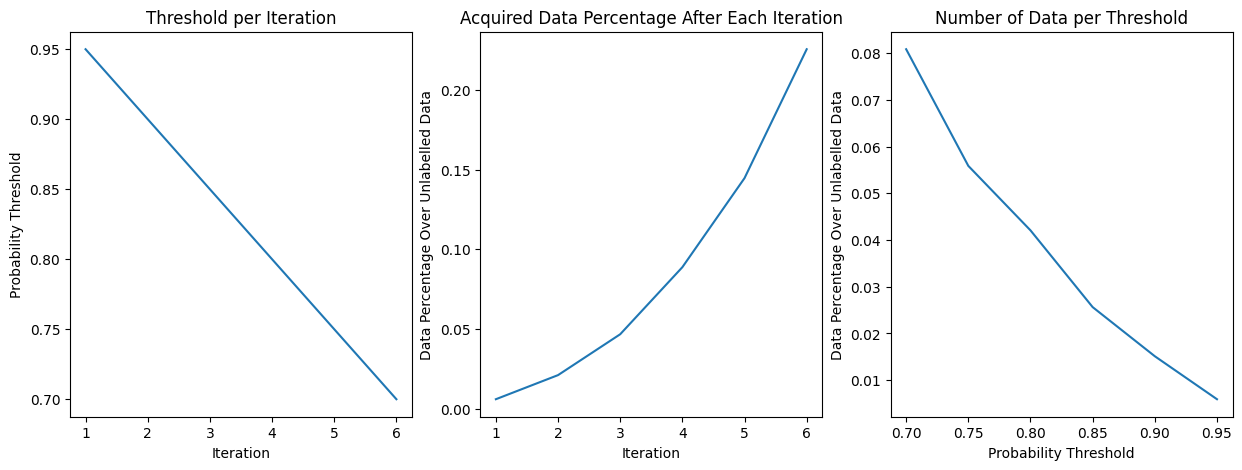

In [147]:
## visualize pseudolabelling results
temp_list = dict(sorted(threshold_iteration_dict.items()))
plt.figure(figsize=(15, 5))
a, b, c = zip(*temp_list.values())

plt.subplot(1, 3, 1)
plt.plot(temp_list.keys(), a)
plt.xlabel("Iteration")
plt.ylabel("Probability Threshold")
plt.title("Threshold per Iteration")

plt.subplot(1, 3, 2)
plt.plot(temp_list.keys(), b)
plt.xlabel("Iteration")
plt.ylabel("Data Percentage Over Unlabelled Data")
plt.title("Acquired Data Percentage After Each Iteration")

a = list(threshold_acc_dict.values())
a = [a/psd_test_size for a in a]
plt.subplot(1, 3, 3)
plt.plot(threshold_acc_dict.keys(), a)
plt.xlabel("Probability Threshold")
plt.ylabel("Data Percentage Over Unlabelled Data")
plt.title("Number of Data per Threshold")
plt.show()

In [148]:
print('================================================================')
print('Threshold per Iteration')
print(threshold_iteration_dict)
print()

print('Number of Data per Threshold')
print(threshold_acc_dict)
print('================================================================')

Threshold per Iteration
{1: (0.95, 0.005917159763313609, 9), 2: (0.8999999999999999, 0.0210387902695595, 32), 3: (0.8499999999999999, 0.04667981591058514, 71), 4: (0.7999999999999998, 0.08875739644970414, 135), 5: (0.7499999999999998, 0.14464168310322156, 220), 6: (0.6999999999999997, 0.2255095332018409, 343)}

Number of Data per Threshold
{0.95: 9, 0.8999999999999999: 23, 0.8499999999999999: 39, 0.7999999999999998: 64, 0.7499999999999998: 85, 0.6999999999999997: 123}


In [149]:
## slice data for EMITEN
news_data = pseudolabelled_news_all.iloc[psd_train_size:].sort_values(by=['published date'], ascending=False)
news_data.reset_index(drop=True, inplace=True)

## save data
news_data.to_csv(f"Labelled News Data/Labelled_News_{EMITEN}.csv")
news_data

,title,sentiment,kode_emiten,cleaned,description,published date,url,publisher,keywords,content,published_date,kode_emitten
0,Sumber Global Energy (SGER) Akan Bagikan Divid...,2.0,NaN,sumber global energy sger bagi dividen saham s...,Sumber Global Energy (SGER) Akan Bagikan Divid...,2023-09-25,https://news.google.com/rss/articles/CBMiZ2h0d...,"{'href': 'https://investor.id', 'title': 'Inve...",Missing,Missing,NaN,NaN
1,Mengubur Kesan Invasi pada Investasi Pertamban...,1.0,NaN,kubur kesan invasi investasi tambang,Mengubur Kesan Invasi pada Investasi Pertamban...,2023-09-23,https://news.google.com/rss/articles/CBMiZGh0d...,"{'href': 'https://investor.id', 'title': 'Inve...",Missing,Missing,NaN,NaN
2,Sumber Global Energy (SGER) Mau Bagi-bagi Divi...,2.0,NaN,sumber global energy sger bagibagi dividen saham,Sumber Global Energy (SGER) Mau Bagi-bagi Divi...,2023-09-21,https://news.google.com/rss/articles/CBMiVmh0d...,"{'href': 'https://investor.id', 'title': 'Inve...",Missing,Missing,NaN,NaN
3,"Margin Diramal Membaik, Saham MBMA dan NCKL Ja...",2.0,NaN,margin ramal baik saham mbma nckl top picks se...,"Margin Diramal Membaik, Saham MBMA dan NCKL Ja...",2023-09-18,https://news.google.com/rss/articles/CBMid2h0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['margin', 'produksi', 'logam', 'tambang', 'to...",ILUSTRASI. Fasilitas pengolahan nikel PT Trime...,NaN,NaN
4,"Prediksi IHSG Besok Jelang FOMC, Rekomendasi S...",2.0,NaN,prediksi ihsg besok jelang fomc rekomendasi sa...,"Prediksi IHSG Besok Jelang FOMC, Rekomendasi S...",2023-09-18,https://news.google.com/rss/articles/CBMicWh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['prediksi', 'rekomendasi', 'fed', 'sekuritas'...",IHSG diprediksi bergerak di rentang 6.889-7.02...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
338,"Pacu 4 Jalan Tol, Citra Marga Nusaphala (CMNP)...",2.0,NaN,pacu jalan tol citra marga nusaphala cmnp siap...,"Pacu 4 Jalan Tol, Citra Marga Nusaphala (CMNP)...",2019-01-22,https://news.google.com/rss/articles/CBMidGh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['triliun', 'tito', 'marga', 'citra', 'nusapha...",PT Citra Marga Nusaphala Persada Tbk. menyiapk...,NaN,NaN
339,PROYEKSI 2019: Indeks Bisnis-27 Berpotensi Reb...,2.0,NaN,proyeksi indeks bisnis potensi rebound,PROYEKSI 2019: Indeks Bisnis-27 Berpotensi Reb...,2019-01-02,https://news.google.com/rss/articles/CBMiYmh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['tingginya', '2019', 'investor', 'rebound', '...",Kinerja Indeks Bisnis-27 sepanjang tahun ini d...,NaN,NaN
340,Sektor finansial dan konstruksi dorong IHSG me...,2.0,NaN,sektor finansial konstruksi dorong ihsg kuat sesi,Sektor finansial dan konstruksi dorong IHSG me...,2018-11-22,https://news.google.com/rss/articles/CBMiZGh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['06', 'rp', 'menguat', 'sanny', 'diikuti', 't...",ILUSTRASI. Bursa Efek Indonesia\r\n\r\nReporte...,NaN,NaN
341,ADRO Targetkan Produksi AMC 1 Juta Ton - Bisni...,1.0,NaN,adro target produksi amc juta ton,ADRO Targetkan Produksi AMC 1 Juta Ton Bisnis...,2018-11-07,https://news.google.com/rss/articles/CBMiWWh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['yoy', 'produksi', 'batu', 'ton', 'bara', 'ad...","Smallest Font Largest Font\r\n\r\nBisnis.com, ...",NaN,NaN


In [150]:
temp = pseudolabelled_news_all.reset_index(drop=True)
temp.to_csv('Labelled News Data\Labelled_News_All.csv')

# Data Fusion of Historical and News Sentiment

## Merging with Outer

In [159]:
# Rename columns
news_data.rename(columns={"published date": "datetime"}, inplace=True)

# conform data type
news_data['datetime'] = news_data['datetime'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
stock_data["datetime"] = stock_data["datetime"].apply(lambda x: x.replace(hour=00, minute=00))
stock_data

C:\Users\hufah\AppData\Local\Temp\ipykernel_156\2475103106.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["datetime"] = stock_data["datetime"].apply(lambda x: x.replace(hour=00, minute=00))


,datetime,symbol,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,...,EMA_20,SMA_50,EMA_50,RSI,MACD,MACD_SIGNAL,UPPERBAND,MIDDLEBAND,LOWERBAND,target_10
0,2018-07-12,IDX:BRPT,347.975495,377.801966,347.975495,370.842456,1.424580e+08,355.133848,360.295916,364.181211,...,387.193605,436.003353,421.003184,40.638118,-24.186028,-22.312679,462.164807,394.256236,326.347665,sell
1,2018-07-13,IDX:BRPT,371.836672,385.755692,371.836672,375.813535,1.388753e+08,361.695672,365.468456,362.391623,...,386.109789,433.179781,419.231040,42.614307,-22.112692,-22.272681,456.881204,391.273589,325.665974,sell
2,2018-07-16,IDX:BRPT,376.807750,381.778829,354.935005,365.871378,1.073670e+08,362.689888,365.602763,359.607819,...,384.182321,430.236902,417.138505,39.763180,-21.029393,-22.024024,452.478079,388.191520,323.904961,sell
3,2018-07-17,IDX:BRPT,365.871378,365.871378,350.958142,360.900299,1.008820e+08,364.280633,364.035275,358.911868,...,381.964986,427.194602,414.933085,38.380485,-20.337557,-21.686730,445.937908,384.463211,322.988514,sell
4,2018-07-18,IDX:BRPT,361.894515,361.894515,353.940789,353.940789,6.741998e+07,365.473691,360.670447,358.613603,...,379.296015,423.973343,412.541230,36.468536,-20.118927,-21.373170,440.692204,380.884035,321.075866,buy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,2023-09-19,IDX:BRPT,1437.698880,1457.666920,1407.746820,1432.706870,9.852224e+07,1352.834710,1364.940445,1256.488917,...,1183.880665,948.581740,1019.954813,83.169442,126.057662,103.010197,1439.284719,1169.877544,900.470368,sell
1265,2023-09-20,IDX:BRPT,1432.706870,1477.634960,1417.730840,1442.690890,9.809105e+07,1400.758006,1390.857260,1284.444173,...,1208.529258,962.359688,1036.532699,83.530371,131.021181,108.612394,1460.356632,1197.333599,934.310565,sell
1266,2023-09-21,IDX:BRPT,1447.682900,1497.603000,1432.706870,1477.634960,1.427811e+08,1440.694086,1419.783160,1319.388243,...,1234.158372,976.636836,1053.830827,84.762063,136.204421,114.130799,1494.578045,1221.295247,948.012448,sell
1267,2023-09-22,IDX:BRPT,1467.650940,1512.579030,1447.682900,1482.626970,1.148547e+08,1453.673312,1440.731097,1353.833112,...,1257.822048,990.913985,1070.646362,84.935388,139.111400,119.126919,1524.781831,1244.008892,963.235953,sell


In [160]:
# Merge data
merge_data = pd.merge(news_data, stock_data, on='datetime', how="outer")
merge_data = merge_data.drop(columns=['title', 'description', 'url', 'publisher', 'keywords', 'content', 'cleaned'])
merge_data.sort_values(by=["datetime"], ascending=True, inplace=True)
merge_data.reset_index(inplace=True, drop=True)
merge_data

,datetime,sentiment,symbol,open,high,low,close,volume,SMA_5,EMA_5,...,EMA_20,SMA_50,EMA_50,RSI,MACD,MACD_SIGNAL,UPPERBAND,MIDDLEBAND,LOWERBAND,target_10
0,2018-07-12,NaN,IDX:BRPT,347.975495,377.801966,347.975495,370.842456,1.424580e+08,355.133848,360.295916,...,387.193605,436.003353,421.003184,40.638118,-24.186028,-22.312679,462.164807,394.256236,326.347665,sell
1,2018-07-13,NaN,IDX:BRPT,371.836672,385.755692,371.836672,375.813535,1.388753e+08,361.695672,365.468456,...,386.109789,433.179781,419.231040,42.614307,-22.112692,-22.272681,456.881204,391.273589,325.665974,sell
2,2018-07-16,NaN,IDX:BRPT,376.807750,381.778829,354.935005,365.871378,1.073670e+08,362.689888,365.602763,...,384.182321,430.236902,417.138505,39.763180,-21.029393,-22.024024,452.478079,388.191520,323.904961,sell
3,2018-07-17,NaN,IDX:BRPT,365.871378,365.871378,350.958142,360.900299,1.008820e+08,364.280633,364.035275,...,381.964986,427.194602,414.933085,38.380485,-20.337557,-21.686730,445.937908,384.463211,322.988514,sell
4,2018-07-18,NaN,IDX:BRPT,361.894515,361.894515,353.940789,353.940789,6.741998e+07,365.473691,360.670447,...,379.296015,423.973343,412.541230,36.468536,-20.118927,-21.373170,440.692204,380.884035,321.075866,buy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2444,2023-09-25,positive,IDX:BRPT,1502.595010,1517.571040,1467.650940,1472.642950,1.017886e+08,1461.660528,1451.368381,...,1278.281182,1004.991453,1086.410934,82.904302,139.007186,123.102973,1552.527450,1262.229729,971.932007,sell
2445,2023-09-25,positive,IDX:BRPT,1502.595010,1517.571040,1467.650940,1472.642950,1.017886e+08,1461.660528,1451.368381,...,1278.281182,1004.991453,1086.410934,82.904302,139.007186,123.102973,1552.527450,1262.229729,971.932007,sell
2446,2023-09-25,positive,IDX:BRPT,1502.595010,1517.571040,1467.650940,1472.642950,1.017886e+08,1461.660528,1451.368381,...,1278.281182,1004.991453,1086.410934,82.904302,139.007186,123.102973,1552.527450,1262.229729,971.932007,sell
2447,2023-09-25,positive,IDX:BRPT,1502.595010,1517.571040,1467.650940,1472.642950,1.017886e+08,1461.660528,1451.368381,...,1278.281182,1004.991453,1086.410934,82.904302,139.007186,123.102973,1552.527450,1262.229729,971.932007,sell


## Agregate Sentiment

In [161]:
temp_2 = merge_data[["datetime", "sentiment"]]
temp_2 = temp_2.groupby(["datetime", "sentiment"]).size().to_frame("agg")
temp_2 = temp_2.pivot_table(values="agg", index=["datetime"], columns="sentiment")
temp_2.reset_index(inplace=True)
temp_2

sentiment,datetime,negative,positive
0,2018-10-21,NaN,1.0
1,2018-10-22,NaN,1.0
2,2018-10-24,NaN,2.0
3,2018-10-25,NaN,2.0
4,2018-10-26,1.0,NaN
...,...,...,...
1032,2023-09-21,NaN,4.0
1033,2023-09-22,NaN,4.0
1034,2023-09-23,NaN,2.0
1035,2023-09-24,NaN,1.0


In [162]:
merge_data.drop_duplicates(subset='datetime', keep="first", inplace=True)
merge_data.drop(columns=["sentiment"], inplace=True)
merge_data.reset_index(inplace=True, drop=True)
merge_data = pd.merge(merge_data, temp_2, on='datetime', how='left')
merge_data

,datetime,symbol,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,...,EMA_50,RSI,MACD,MACD_SIGNAL,UPPERBAND,MIDDLEBAND,LOWERBAND,target_10,negative,positive
0,2018-07-12,IDX:BRPT,347.975495,377.801966,347.975495,370.842456,1.424580e+08,355.133848,360.295916,364.181211,...,421.003184,40.638118,-24.186028,-22.312679,462.164807,394.256236,326.347665,sell,NaN,NaN
1,2018-07-13,IDX:BRPT,371.836672,385.755692,371.836672,375.813535,1.388753e+08,361.695672,365.468456,362.391623,...,419.231040,42.614307,-22.112692,-22.272681,456.881204,391.273589,325.665974,sell,NaN,NaN
2,2018-07-16,IDX:BRPT,376.807750,381.778829,354.935005,365.871378,1.073670e+08,362.689888,365.602763,359.607819,...,417.138505,39.763180,-21.029393,-22.024024,452.478079,388.191520,323.904961,sell,NaN,NaN
3,2018-07-17,IDX:BRPT,365.871378,365.871378,350.958142,360.900299,1.008820e+08,364.280633,364.035275,358.911868,...,414.933085,38.380485,-20.337557,-21.686730,445.937908,384.463211,322.988514,sell,NaN,NaN
4,2018-07-18,IDX:BRPT,361.894515,361.894515,353.940789,353.940789,6.741998e+07,365.473691,360.670447,358.613603,...,412.541230,36.468536,-20.118927,-21.373170,440.692204,380.884035,321.075866,buy,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1474,2023-09-21,IDX:BRPT,1447.682900,1497.603000,1432.706870,1477.634960,1.427811e+08,1440.694086,1419.783160,1319.388243,...,1053.830827,84.762063,136.204421,114.130799,1494.578045,1221.295247,948.012448,sell,NaN,4.0
1475,2023-09-22,IDX:BRPT,1467.650940,1512.579030,1447.682900,1482.626970,1.148547e+08,1453.673312,1440.731097,1353.833112,...,1070.646362,84.935388,139.111400,119.126919,1524.781831,1244.008892,963.235953,sell,NaN,4.0
1476,2023-09-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1477,2023-09-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


## Aggregate Data Holidays

In [163]:
values = {"negative": 0, "positive": 0}
merge_data.fillna(value = values, inplace=True)

# Add values from holiday dates to business dates
holidays = merge_data[merge_data["symbol"].isnull()].index
for ind in holidays:
    i = 1
    while(pd.isnull(merge_data.loc[ind + i, "symbol"])):
        i += 1
    merge_data.loc[ind + i, "negative"] += merge_data.loc[ind, "negative"]
    merge_data.loc[ind + i, "positive"] += merge_data.loc[ind, "positive"]
    merge_data.drop([ind], axis=0, inplace=True)

merge_data.reset_index(inplace=True, drop=True)
merge_data["total_news"] = merge_data["negative"] + merge_data["positive"]
merge_data

,datetime,symbol,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,...,RSI,MACD,MACD_SIGNAL,UPPERBAND,MIDDLEBAND,LOWERBAND,target_10,negative,positive,total_news
0,2018-07-12,IDX:BRPT,347.975495,377.801966,347.975495,370.842456,1.424580e+08,355.133848,360.295916,364.181211,...,40.638118,-24.186028,-22.312679,462.164807,394.256236,326.347665,sell,0.0,0.0,0.0
1,2018-07-13,IDX:BRPT,371.836672,385.755692,371.836672,375.813535,1.388753e+08,361.695672,365.468456,362.391623,...,42.614307,-22.112692,-22.272681,456.881204,391.273589,325.665974,sell,0.0,0.0,0.0
2,2018-07-16,IDX:BRPT,376.807750,381.778829,354.935005,365.871378,1.073670e+08,362.689888,365.602763,359.607819,...,39.763180,-21.029393,-22.024024,452.478079,388.191520,323.904961,sell,0.0,0.0,0.0
3,2018-07-17,IDX:BRPT,365.871378,365.871378,350.958142,360.900299,1.008820e+08,364.280633,364.035275,358.911868,...,38.380485,-20.337557,-21.686730,445.937908,384.463211,322.988514,sell,0.0,0.0,0.0
4,2018-07-18,IDX:BRPT,361.894515,361.894515,353.940789,353.940789,6.741998e+07,365.473691,360.670447,358.613603,...,36.468536,-20.118927,-21.373170,440.692204,380.884035,321.075866,buy,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,2023-09-19,IDX:BRPT,1437.698880,1457.666920,1407.746820,1432.706870,9.852224e+07,1352.834710,1364.940445,1256.488917,...,83.169442,126.057662,103.010197,1439.284719,1169.877544,900.470368,sell,0.0,2.0,2.0
1265,2023-09-20,IDX:BRPT,1432.706870,1477.634960,1417.730840,1442.690890,9.809105e+07,1400.758006,1390.857260,1284.444173,...,83.530371,131.021181,108.612394,1460.356632,1197.333599,934.310565,sell,1.0,5.0,6.0
1266,2023-09-21,IDX:BRPT,1447.682900,1497.603000,1432.706870,1477.634960,1.427811e+08,1440.694086,1419.783160,1319.388243,...,84.762063,136.204421,114.130799,1494.578045,1221.295247,948.012448,sell,0.0,4.0,4.0
1267,2023-09-22,IDX:BRPT,1467.650940,1512.579030,1447.682900,1482.626970,1.148547e+08,1453.673312,1440.731097,1353.833112,...,84.935388,139.111400,119.126919,1524.781831,1244.008892,963.235953,sell,0.0,4.0,4.0


## Apply Final Sentiment

In [164]:
merge_data["sentiment"] = merge_data.apply(lambda x: apply_sentiment(x), axis=1)
merge_data

,datetime,symbol,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,...,MACD,MACD_SIGNAL,UPPERBAND,MIDDLEBAND,LOWERBAND,target_10,negative,positive,total_news,sentiment
0,2018-07-12,IDX:BRPT,347.975495,377.801966,347.975495,370.842456,1.424580e+08,355.133848,360.295916,364.181211,...,-24.186028,-22.312679,462.164807,394.256236,326.347665,sell,0.0,0.0,0.0,no sentiment
1,2018-07-13,IDX:BRPT,371.836672,385.755692,371.836672,375.813535,1.388753e+08,361.695672,365.468456,362.391623,...,-22.112692,-22.272681,456.881204,391.273589,325.665974,sell,0.0,0.0,0.0,no sentiment
2,2018-07-16,IDX:BRPT,376.807750,381.778829,354.935005,365.871378,1.073670e+08,362.689888,365.602763,359.607819,...,-21.029393,-22.024024,452.478079,388.191520,323.904961,sell,0.0,0.0,0.0,no sentiment
3,2018-07-17,IDX:BRPT,365.871378,365.871378,350.958142,360.900299,1.008820e+08,364.280633,364.035275,358.911868,...,-20.337557,-21.686730,445.937908,384.463211,322.988514,sell,0.0,0.0,0.0,no sentiment
4,2018-07-18,IDX:BRPT,361.894515,361.894515,353.940789,353.940789,6.741998e+07,365.473691,360.670447,358.613603,...,-20.118927,-21.373170,440.692204,380.884035,321.075866,buy,0.0,0.0,0.0,no sentiment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,2023-09-19,IDX:BRPT,1437.698880,1457.666920,1407.746820,1432.706870,9.852224e+07,1352.834710,1364.940445,1256.488917,...,126.057662,103.010197,1439.284719,1169.877544,900.470368,sell,0.0,2.0,2.0,positive
1265,2023-09-20,IDX:BRPT,1432.706870,1477.634960,1417.730840,1442.690890,9.809105e+07,1400.758006,1390.857260,1284.444173,...,131.021181,108.612394,1460.356632,1197.333599,934.310565,sell,1.0,5.0,6.0,positive
1266,2023-09-21,IDX:BRPT,1447.682900,1497.603000,1432.706870,1477.634960,1.427811e+08,1440.694086,1419.783160,1319.388243,...,136.204421,114.130799,1494.578045,1221.295247,948.012448,sell,0.0,4.0,4.0,positive
1267,2023-09-22,IDX:BRPT,1467.650940,1512.579030,1447.682900,1482.626970,1.148547e+08,1453.673312,1440.731097,1353.833112,...,139.111400,119.126919,1524.781831,1244.008892,963.235953,sell,0.0,4.0,4.0,positive


## Sentiment Visualization

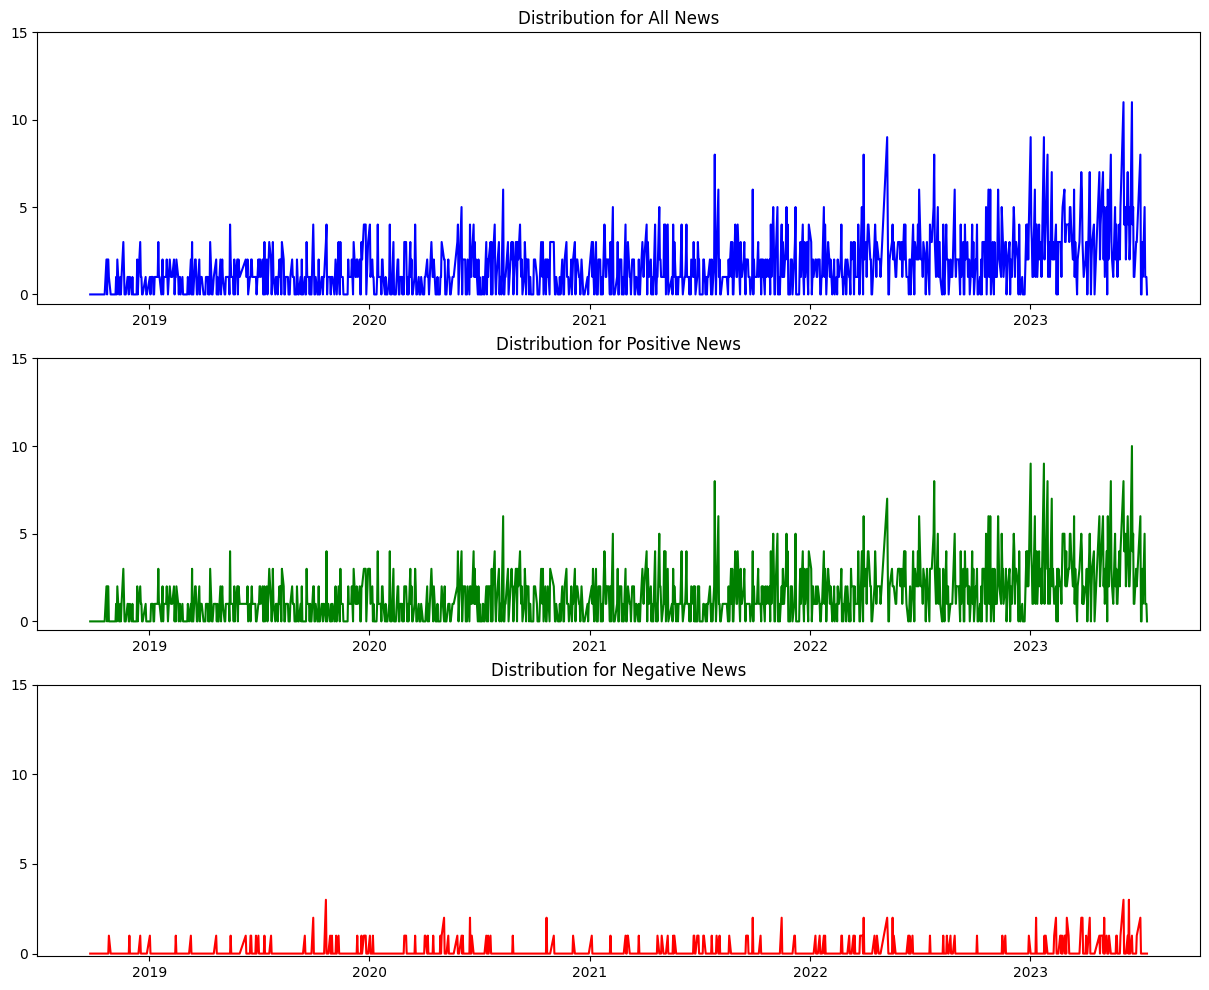

In [165]:
plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
plt.plot(merge_data.loc[50:merge_data.shape[0]-50, 'datetime'], merge_data.loc[50:merge_data.shape[0]-50, 'total_news'], color='blue')
plt.yticks(np.arange(0, merge_data['total_news'].max() + 1, 5))
plt.title('Distribution for All News')

plt.subplot(3, 1, 2)
plt.plot(merge_data.loc[50:merge_data.shape[0]-50, 'datetime'], merge_data.loc[50:merge_data.shape[0]-50, 'positive'], color='green')
plt.yticks(np.arange(0, merge_data['total_news'].max() + 1, 5))
plt.title('Distribution for Positive News')


plt.subplot(3, 1, 3)
plt.plot(merge_data.loc[50:merge_data.shape[0]-50, 'datetime'], merge_data.loc[50:merge_data.shape[0]-50, 'negative'], color='red')
plt.yticks(np.arange(0, merge_data['total_news'].max() + 1, 5))
plt.title('Distribution for Negative News')

plt.show()

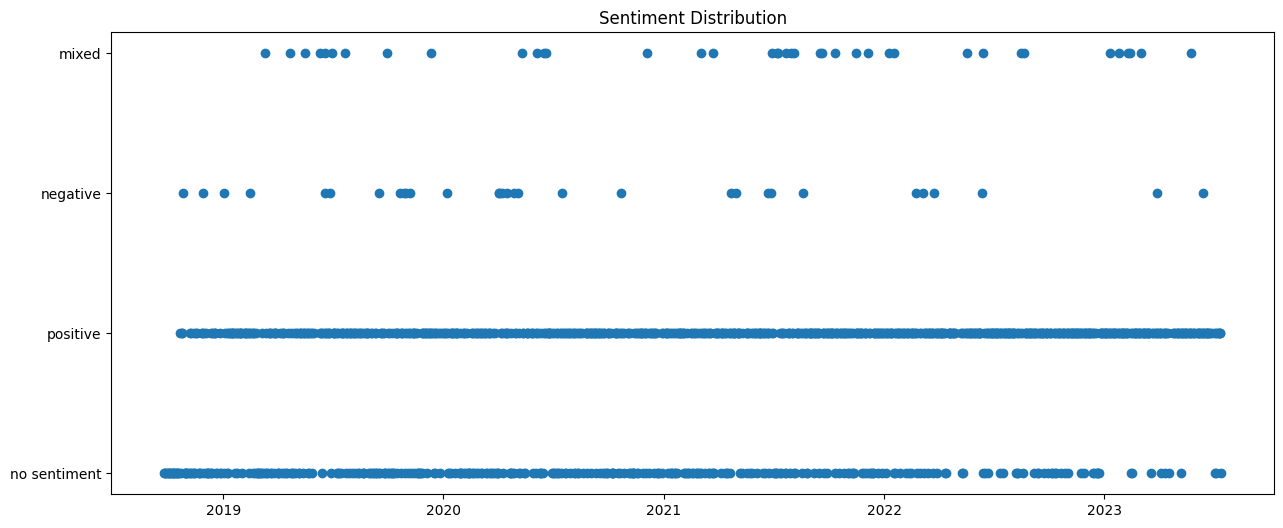

In [166]:
plt.figure(figsize=(15, 6))

plt.scatter(merge_data.loc[50:merge_data.shape[0]-50, 'datetime'], merge_data.loc[50:merge_data.shape[0]-50, 'sentiment'])
plt.title('Sentiment Distribution')
plt.show()

In [167]:
merge_data.loc[50:merge_data.shape[0]-50, 'sentiment'].value_counts()

sentiment
positive        745
no sentiment    355
mixed            39
negative         31
Name: count, dtype: int64

## Label Encoding for Final Sentiment and Buy/Sell Label

In [ ]:
le = LabelEncoder()
le.classes_ = np.array(["negative", "no sentiment", "mixed", "positive"])
merge_data["sentiment"] = le.transform(merge_data["sentiment"]) - 1

le.classes_ = np.array(["sell", "buy"])
merge_data['target_10'] = le.transform(merge_data['target_10'])

merge_data

# Modelling

## Split Features and Target

In [169]:
x = merge_data.copy()
y = x[['target_10']]

x.drop([
        'symbol',
        ], axis=1, inplace=True)

for col in y.columns:
    x.drop([col], axis=1, inplace=True)
    
x.set_index("datetime", inplace=True)
x

,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,EMA_10,SMA_20,...,RSI,MACD,MACD_SIGNAL,UPPERBAND,MIDDLEBAND,LOWERBAND,negative,positive,total_news,sentiment
datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-12,347.975495,377.801966,347.975495,370.842456,1.424580e+08,355.133848,360.295916,364.181211,368.230655,394.256236,...,40.638118,-24.186028,-22.312679,462.164807,394.256236,326.347665,0.0,0.0,0.0,0
2018-07-13,371.836672,385.755692,371.836672,375.813535,1.388753e+08,361.695672,365.468456,362.391623,369.609361,391.273589,...,42.614307,-22.112692,-22.272681,456.881204,391.273589,325.665974,0.0,0.0,0.0,0
2018-07-16,376.807750,381.778829,354.935005,365.871378,1.073670e+08,362.689888,365.602763,359.607819,368.929727,388.191520,...,39.763180,-21.029393,-22.024024,452.478079,388.191520,323.904961,0.0,0.0,0.0,0
2018-07-17,365.871378,365.871378,350.958142,360.900299,1.008820e+08,364.280633,364.035275,358.911868,367.469831,384.463211,...,38.380485,-20.337557,-21.686730,445.937908,384.463211,322.988514,0.0,0.0,0.0,0
2018-07-18,361.894515,361.894515,353.940789,353.940789,6.741998e+07,365.473691,360.670447,358.613603,365.010006,380.884035,...,36.468536,-20.118927,-21.373170,440.692204,380.884035,321.075866,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-19,1437.698880,1457.666920,1407.746820,1432.706870,9.852224e+07,1352.834710,1364.940445,1256.488917,1287.737636,1169.877544,...,83.169442,126.057662,103.010197,1439.284719,1169.877544,900.470368,0.0,2.0,2.0,2
2023-09-20,1432.706870,1477.634960,1417.730840,1442.690890,9.809105e+07,1400.758006,1390.857260,1284.444173,1315.910955,1197.333599,...,83.530371,131.021181,108.612394,1460.356632,1197.333599,934.310565,1.0,5.0,6.0,2
2023-09-21,1447.682900,1497.603000,1432.706870,1477.634960,1.427811e+08,1440.694086,1419.783160,1319.388243,1345.315319,1221.295247,...,84.762063,136.204421,114.130799,1494.578045,1221.295247,948.012448,0.0,4.0,4.0,2


## Split Train/Test

In [170]:
x_copy = x.copy()

x = x.iloc[50:]
y = y.iloc[50:]

training_size = int((x.shape[0]) * 0.8)

x_train = x.iloc[:training_size]
y_train = y.iloc[:training_size]

x_test = x.iloc[training_size:]
y_test = y.iloc[training_size:]

print(f"Training Size: {x_train.shape[0]}")
print(f"Test Size: {x_test.shape[0]}")
x_train.shape

Training Size: 975
Test Size: 244


(975, 23)

## Feature Scaling

In [171]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(np.array(x_train))
x_test = scaler.transform(np.array(x_test))
x_train

array([[0.0352349 , 0.03171953, 0.03577513, ..., 0.        , 0.        ,
        0.33333333],
       [0.03439597, 0.03672788, 0.03747871, ..., 0.        , 0.        ,
        0.33333333],
       [0.03439597, 0.04340568, 0.03918228, ..., 0.        , 0.        ,
        0.33333333],
       ...,
       [0.40436242, 0.4115192 , 0.4165247 , ..., 0.125     , 0.11111111,
        1.        ],
       [0.41275168, 0.4115192 , 0.4165247 , ..., 0.125     , 0.11111111,
        1.        ],
       [0.40855705, 0.43656093, 0.42078365, ..., 0.25      , 0.22222222,
        1.        ]])

## PCA

In [172]:
pca = PCA()
pca.fit(np.array(x_train))
print(np.cumsum(pca.explained_variance_ratio_))
n_comp = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.95) + 1
print(f'pca dimensions: {n_comp}')

pca = PCA(n_components=n_comp)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
x_train[:5]

[0.69853068 0.84529911 0.93342294 0.96057625 0.97471689 0.98508108
 0.99304281 0.99660294 0.99839799 0.99915986 0.99945416 0.99963735
 0.99979234 0.99990374 0.99994998 0.99999229 0.99999705 0.99999989
 0.99999999 1.         1.         1.         1.        ]
pca dimensions: 4


array([[ 1.89636222,  0.33234397, -0.0169975 ,  0.00430362],
       [ 1.89149035,  0.33330267, -0.02161599,  0.00419623],
       [ 1.88672129,  0.33605751, -0.04049968,  0.00374497],
       [ 1.8828952 ,  0.33643735, -0.04275253,  0.00439079],
       [ 1.881749  ,  0.33411979, -0.0223336 ,  0.00405305]])

## Create Sliding Window

In [173]:
data_size = x_copy.shape[0]
window_size = 10
new_x = []

for i in range(data_size - window_size + 1):
    new_x.append(x_copy[i:i + window_size])
new_x = np.array(new_x)[50+1 - window_size:]
new_x
new_x.shape

(1219, 10, 23)

## Apply Sliding Window to With Feature Scaling and PCA

In [174]:
new_x_pca = np.zeros((new_x.shape[0], window_size, n_comp))

for i in range(new_x.shape[0]):
        new_x[i] = scaler.transform(new_x[i])
        new_x_pca[i] = pca.transform(new_x[i])
    
new_x = new_x[:, :].reshape(new_x.shape[0], -1)
new_x_pca = new_x_pca[:, :].reshape(new_x_pca.shape[0], -1)
x_train = new_x_pca[:training_size]
x_test = new_x_pca[training_size:]

print(x_train.shape)
x_train

(975, 40)


array([[ 1.93429863,  0.29664488,  0.26092907, ...,  0.33234397,
        -0.0169975 ,  0.00430362],
       [ 1.94771131,  0.29862646,  0.23655984, ...,  0.33330267,
        -0.02161599,  0.00419623],
       [ 1.93965813,  0.31455417,  0.10775639, ...,  0.33605751,
        -0.04049968,  0.00374497],
       ...,
       [ 0.11528916,  0.41649755,  0.26638751, ..., -0.26126241,
         0.22781117, -0.14834201],
       [ 0.05792578, -0.46983813,  0.11013246, ..., -0.25968686,
         0.21259074, -0.14815125],
       [ 0.06884403, -0.23540543,  0.09397386, ..., -0.3240683 ,
         0.10869402, -0.02792348]])

## Model Training and Predicting

In [190]:
TARGET_DAY = 10
all_results = []
train_target = y_train[f'target_{TARGET_DAY}']
test_target = y_test[f'target_{TARGET_DAY}']
if test_target.nunique() == 3:
    disp_labels = ["sell", "wait", "buy"]
elif test_target.nunique() == 2:
    disp_labels = ["sell", "buy"]
else:
    disp_labels = ["strong sell", "weak sell", "weak buy", "strong buy"]

proba_thres = 0.6
model_list = [('rf', RandomForestClassifier(random_state=0)),
            ('ad', AdaBoostClassifier(random_state=0)),
            ('xg', XGBClassifier(random_state=0)),
            ('sv', SVC(random_state=0, probability=True)),
            ('kn', KNeighborsClassifier())]

## (acc, f1, prec, rec)
scores_dict = {}
estimators  = []
estimators_count = 2
accuracy_scores = []
pred_proba = []
all_pred = []

for mod in model_list:
    mod_name = mod[0]
    if mod_name == 'kn':
        results = {}
        for k in range(1, 102):
            classifier = KNeighborsClassifier(n_neighbors=k)
            classifier.fit(x_train, train_target)
            results[k] = classifier.score(x_test, test_target)
        results = sorted(results.items(), key=lambda item: item[1], reverse=True)
        k_effective = results[0][0]
        classifier = KNeighborsClassifier(n_neighbors=k_effective)
        mod_name = mod_name + f'_{k_effective}'
    else:
        classifier = mod[1]
    
    classifier.fit(x_train, train_target)
    y_pred = classifier.predict(x_test)
    y_proba = classifier.predict_proba(x_test)
    for i in range(len(y_proba)):
        if y_proba[i][1] > proba_thres:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    pred_proba.append((mod_name, y_proba))
    all_pred.append((mod_name, y_pred))
    scores_dict[mod_name] = (accuracy_score(test_target, y_pred),
                            classification_report(test_target, y_pred, zero_division=0, target_names=disp_labels, digits=4),
                            confusion_matrix(test_target, y_pred),
                            y_pred, )
    accuracy_scores.append((mod_name, classifier, scores_dict[mod_name][0]))  

accuracy_scores = sorted(accuracy_scores, key=lambda x: x[2], reverse=True)
for i in range(estimators_count):
    estimators.append((accuracy_scores[i][0], accuracy_scores[i][1]))

classifier = VotingClassifier(estimators=estimators, voting='soft')
classifier.fit(x_train, train_target)
y_pred = classifier.predict(x_test)
y_proba = classifier.predict_proba(x_test)
for i in range(len(y_proba)):
        if y_proba[i][1] > proba_thres:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
pred_proba.append(('vt', y_proba))
all_pred.append(('vt', y_pred))

scores_dict['vt'] = (accuracy_score(test_target, y_pred),
                    classification_report(test_target, y_pred, zero_division=0, target_names=disp_labels, digits=4),
                    confusion_matrix(test_target, y_pred))

all_results.append((EMITEN, scores_dict, all_pred, test_target))

# Model Evaluation

## Best Accuracy

In [222]:
[mod[0] for mod in accuracy_scores]

['sv', 'rf', 'xg', 'kn_53', 'ad']

## Classification Report

In [192]:
for key, val in scores_dict.items():
    print(f'======================= {key.upper()} Score =======================')
    print(val[1])

======================= RF Score =======================
              precision    recall  f1-score   support

        sell     0.4331    0.5392    0.4803       102
         buy     0.5983    0.4930    0.5405       142

    accuracy                         0.5123       244
   macro avg     0.5157    0.5161    0.5104       244
weighted avg     0.5292    0.5123    0.5154       244

======================= AD Score =======================
              precision    recall  f1-score   support

        sell     0.4177    0.9706    0.5841       102
         buy     0.5714    0.0282    0.0537       142

    accuracy                         0.4221       244
   macro avg     0.4946    0.4994    0.3189       244
weighted avg     0.5072    0.4221    0.2754       244

======================= XG Score =======================
              precision    recall  f1-score   support

        sell     0.3689    0.3725    0.3707       102
         buy     0.5461    0.5423    0.5442       142

    accurac

## Confusion Matrix

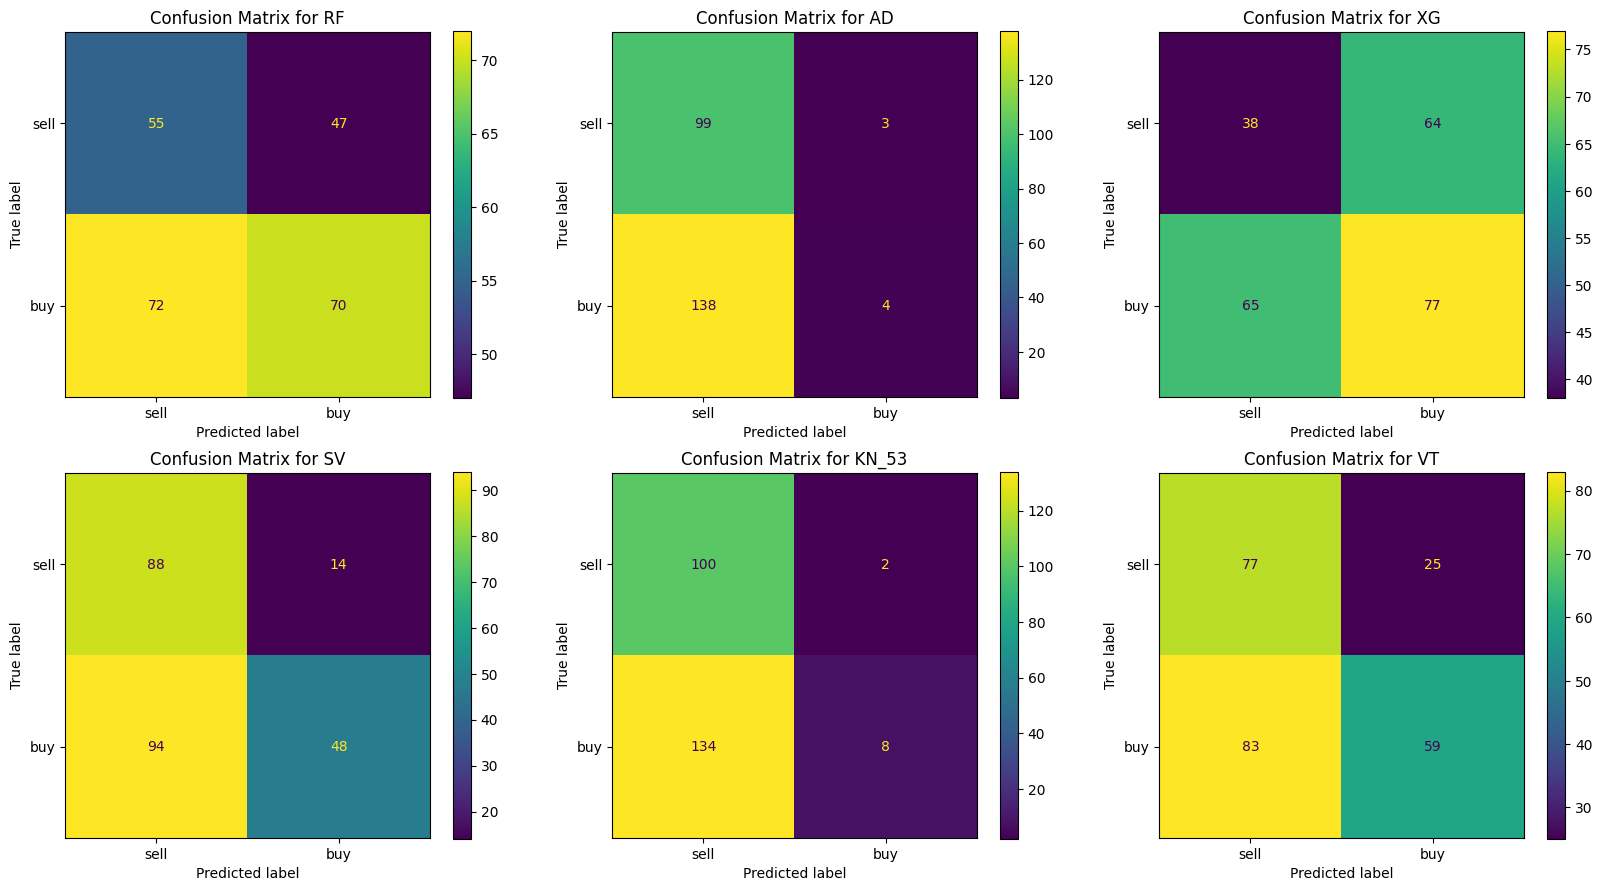

In [193]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10.5))
i = 0

for key, val in scores_dict.items():
    ax[int(i/3), i%3].set_title(f'Confusion Matrix for {key.upper()}')
    ConfusionMatrixDisplay(val[2], display_labels=disp_labels).plot(ax=ax[int(i/3), i%3])
    i += 1
    
plt.show()

# Visualization

In [207]:
index_emiten = 0
train_vis = x[:training_size]
test_vis = x[training_size:]
new_vis = unsliced_stock_data[-51:].set_index('datetime')
pred = all_results[0][2][5][1]
df_result = test_vis.copy()
df_result = df_result.assign(pred=pred)

## Train/Test Visualization

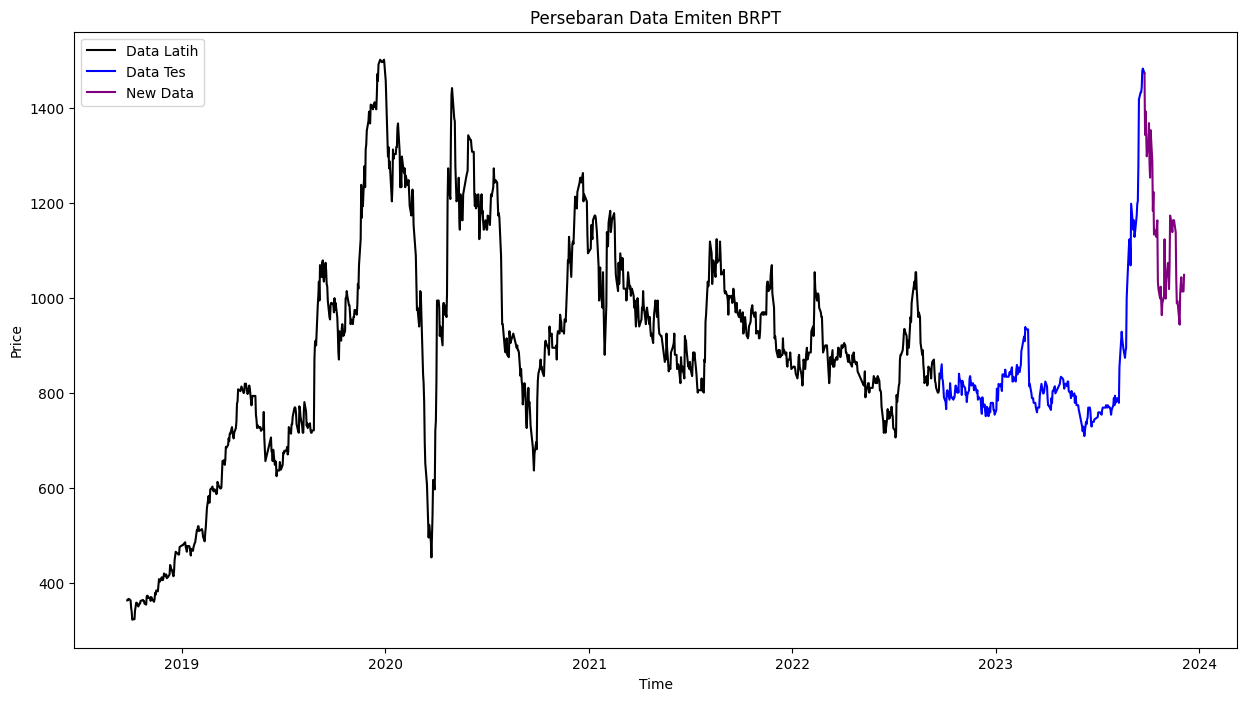

In [208]:
plt.figure(figsize=(15,8))
plt.plot(train_vis.index, train_vis["close"], color='black')
plt.plot(test_vis.index, test_vis["close"], color='blue')
plt.plot(new_vis.index, new_vis["close"], color='purple')
plt.legend(['Data Latih', 'Data Tes', 'New Data'], loc='upper left')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'Persebaran Data Emiten {EMITEN}')
plt.savefig('demo.png', transparent=True)
plt.show()


## Predicted Signals

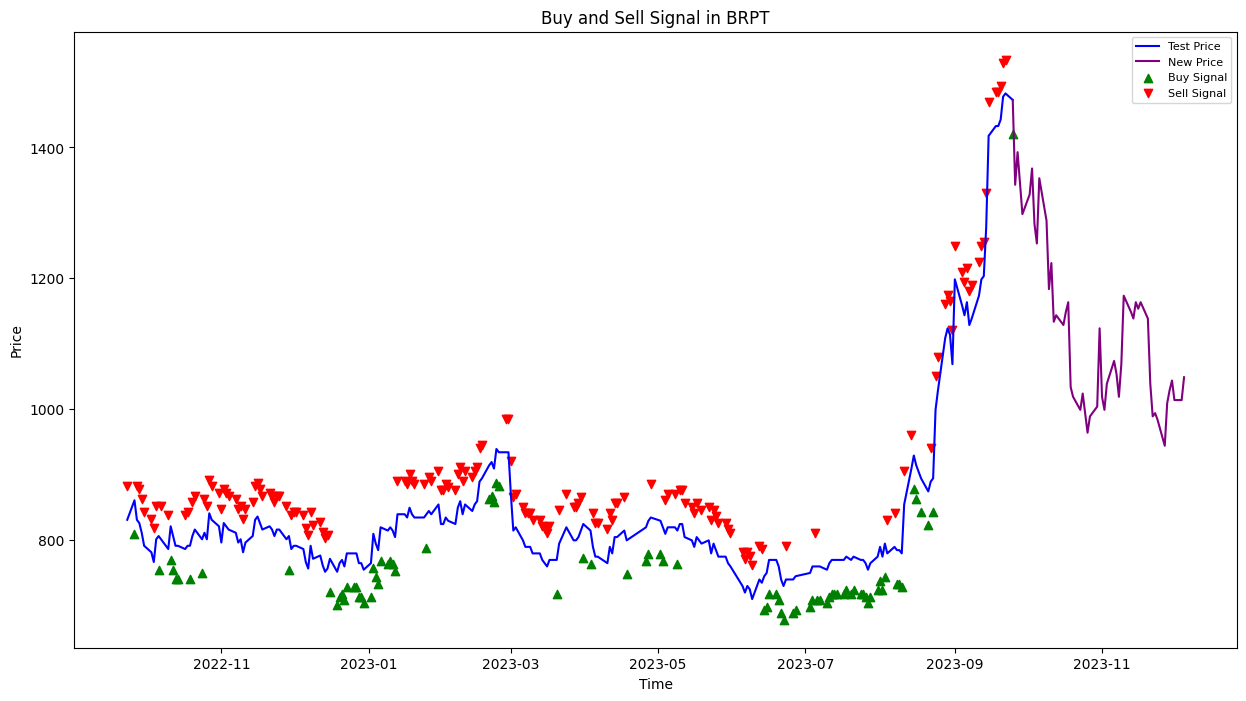

In [210]:
padding = (test_vis['close'].max() - test_vis['close'].min()) / 15

buy_signal = df_result[df_result['pred'] == 1]
sell_signal = df_result[df_result['pred'] == 0]


plt.figure(figsize=(15, 8))
plt.plot(test_vis.index, test_vis["close"], color='blue')
plt.plot(new_vis.index, new_vis["close"], color='purple')
plt.scatter(buy_signal.index, buy_signal["close"] - padding, color='green', marker="^")
plt.scatter(sell_signal.index, sell_signal["close"] + padding, color='red', marker="v")
plt.legend(['Test Price', 'New Price','Buy Signal', 'Sell Signal'], loc='upper right', fontsize=8)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'Buy and Sell Signal in {EMITEN}')
plt.show()

## Profit/Loss Calculations

In [220]:
test_new_df = pd.concat([test_vis, new_vis[1:]])
test_new_df.reset_index(inplace=True)
df_result.reset_index(inplace=True)

init_money = 10000
money = init_money
open_pos = 0
buy_price = 0
sell_price = 0
buy_index_list = []
sell_index_list = []

for i in range(df_result.shape[0]):
    chg = 0
    price = test_new_df.loc[i, 'close']
    if df_result.loc[i, 'pred'] == 1:
        if open_pos == 0:
            buy_price = price
            buy_index = i
            open_pos = 1
            sell_price = 0
            buy_index_list.append(i)

    elif df_result.loc[i, 'pred'] == 0:  
        if open_pos == 1:
            sell_price = price
            chg = (sell_price - buy_price) / buy_price
            money = money + (money * chg)
            buy_price = 0
            buy_index = None
            open_pos = 0
            sell_index_list.append(i)

    if i == (df_result.shape[0] - 1) and open_pos == 1:
        sell_price = test_new_df.loc[df_result.shape[0] + 10, 'close'] 
        chg = (sell_price - buy_price) / buy_price
        money = money + (money * chg)

print(f'initial money: {init_money}')
print(f'after strategy money: {money}')
print(f'profit/loss percentage: {((money - init_money) / init_money) * 100}') 

initial money: 10000
after strategy money: 10674.771607001407
profit/loss percentage: 6.747716070014066


In [219]:
start = test_new_df['close'].iloc[0]
end = test_new_df['close'].iloc[-40]
chg = (end - start) / start
print(f'monet after 5 years original: {init_money + (init_money * chg)}')
print(f'profit/loss percentage: {chg * 100}')

monet after 5 years original: 14732.431768965838
profit/loss percentage: 47.32431768965837


## Buy/Sell After Strategy Implemented

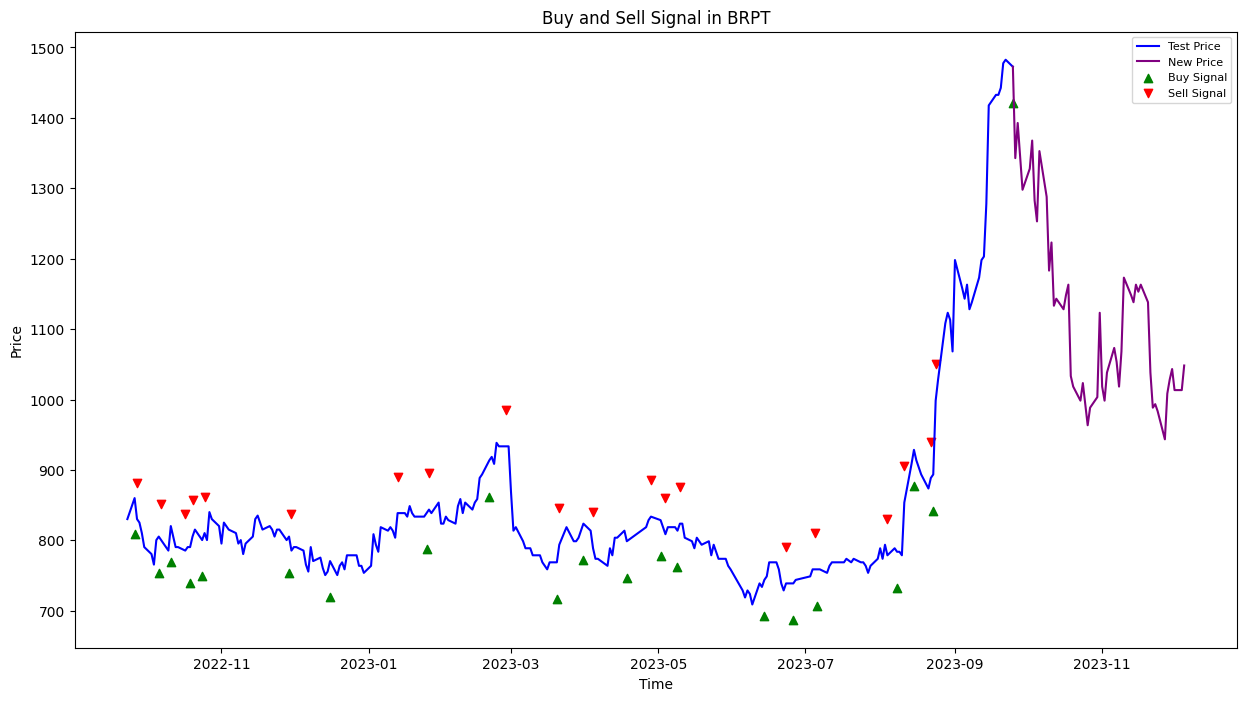

In [221]:
padding = (test_vis['close'].max() - test_vis['close'].min()) / 15

buy_signal = df_result.loc[buy_index_list]
sell_signal = df_result.loc[sell_index_list]


plt.figure(figsize=(15, 8))
plt.plot(test_vis.index, test_vis["close"], color='blue')
plt.plot(new_vis.index, new_vis["close"], color='purple')
plt.scatter(buy_signal['datetime'], buy_signal["close"] - padding, color='green', marker="^")
plt.scatter(sell_signal['datetime'], sell_signal["close"] + padding, color='red', marker="v")
plt.legend(['Test Price', 'New Price','Buy Signal', 'Sell Signal'], loc='upper right', fontsize=8)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'Buy and Sell Signal in {EMITEN}')
plt.show()